In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sliced.datasets import make_cubic
from sliced import SlicedInverseRegression
from sliced import SlicedAverageVarianceEstimation
from sliced import datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.utils.data as Data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import math

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
data=pd.read_csv('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/data_final.csv')

# Generate X Y

In [11]:
###
#cal_PMf  
###
XRestruct_Fun=np.zeros([605,5112])
for i in range (0,605):
    a=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    XRestruct_Fun[i]=a.T

###
#obs_PMf
###
YRestruct_Fun=np.zeros([605,5112])
for i in range (0,605):
    a=np.array(data['pm25_obs'][5112*i:5112*i+5112])
    YRestruct_Fun[i]=a.T

print(np.shape(XRestruct_Fun))
print(np.shape(YRestruct_Fun))

(605, 5112)
(605, 5112)


In [12]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([544,5112])
Yhat_train = np.zeros([544,5112])
Xhat_val = np.zeros([61,5112])
Yhat_val = np.zeros([61,5112])
Xhat_test = np.zeros([61,5112])
Yhat_test = np.zeros([61,5112])

for i in range (0,544):
    for j in range (0,5112):    
        Xhat_train[i][j] = Xhat[i][j]
        Yhat_train[i][j] = Yhat[i][j]
        
for i in range (544,605):
    for j in range (0,5112):
        Xhat_val[i-544][j] = Xhat[i][j]
        Yhat_val[i-544][j] = Yhat[i][j]     
        
for i in range (544,605):
    for j in range (0,5112):
        Xhat_test[i-544][j] = Xhat[i][j]
        Yhat_test[i-544][j] = Yhat[i][j]
print('Xhat_train')
print(np.shape(Xhat_train))
print('Yhat_train')
print(np.shape(Yhat_train))
print('Xhat_val')
print(np.shape(Xhat_val))
print('Yhat_val')
print(np.shape(Yhat_val))
print('Xhat_test')
print(np.shape(Xhat_test))
print('Yhat_test')
print(np.shape(Yhat_test))

Xhat_train
(544, 5112)
Yhat_train
(544, 5112)
Xhat_val
(61, 5112)
Yhat_val
(61, 5112)
Xhat_test
(61, 5112)
Yhat_test
(61, 5112)


# Original data

In [5]:
error1 = mean_absolute_error(Xhat_test, Yhat_test)
error2 = mean_squared_error(Xhat_test, Yhat_test)
print('testing data MAE is ',error1)
print('testing data MAE is ',error2)

testing data MAE is  6.919742865451666
testing data MAE is  90.30246788296535


# Concurrent Model

## 公式解（paper）

In [6]:
XMean_fun=np.zeros(5112)
YMean_fun=np.zeros(5112)
for i in range(0,5112):
    for j in range(0,544):
        XMean_fun[i]=XMean_fun[i]+(XRestruct_Fun[j][i]/544)
        YMean_fun[i]=YMean_fun[i]+(YRestruct_Fun[j][i]/544)
Xbar=XMean_fun
Ybar=YMean_fun
XCov_fun=np.cov(XRestruct_Fun.T)

G_xx=XCov_fun
G_xxt=np.zeros(5112)
for i in range(0,5112):
     G_xxt[i]=G_xx[i][i]
G_xy=0
for i in range (0,544):
    G_xyi=(Xhat_train[i]-Xbar)*(Yhat_train[i]-Ybar)
    G_xy=G_xy+G_xyi
G_xy=G_xy/543

# print(G_xxt)
print(np.shape(G_xxt))
# print(G_xy)
print(np.shape(G_xy))

(5112,)
(5112,)


In [7]:
B_1=G_xy/G_xxt
B_0=YMean_fun-(B_1*XMean_fun)

print('Beta_1')
#print(B_1)
print(np.shape(B_1))
print('Beta_0')
#print(B_0)
print(np.shape(B_0))

fit_x=B_0+(B_1*Xhat_test)
#print(np.shape(fit_x))

Beta_1
(5112,)
Beta_0
(5112,)


In [8]:
error1 = mean_absolute_error(fit_x, Yhat_test)
error2 = mean_squared_error(fit_x, Yhat_test)
print('testing data MAE is ',error1)
print('testing data MAE is ',error2)

testing data MAE is  6.113600206690934
testing data MAE is  64.362257713171


## Gradient descent (loss = MAE)

In [122]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [123]:
def model (x,b0,b1):
    y = b0 +  b1*x
    return y

In [124]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.ones(5112 , requires_grad = True)
beta1 = torch.ones(5112, requires_grad = True)

rate = 1e-2
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 1000
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = torch.abs(yhats_test - y_test)
    test_error_MAE[epoch] = torch.nanmean(r)
    test_error_MSE[epoch] = torch.nanmean(r*r)

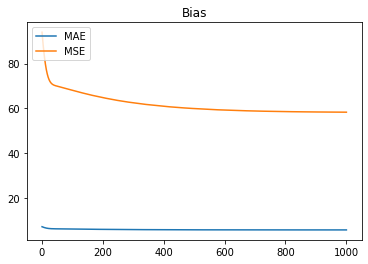

In [86]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('Bias')

plt.show()

In [87]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  5.6217993136645115
testing data MAE is  58.25995203391085


## Gradient descent (loss = MSE)

In [125]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [126]:
def model (x,b0,b1):
    y = b0 +  b1*x
    return y

In [127]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.ones(5112 , requires_grad = True)
beta1 = torch.ones(5112, requires_grad = True)

rate = 1e-2
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 1000
loss = nn.MSELoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = torch.abs(yhats_test - y_test)
    test_error_MAE[epoch] = torch.nanmean(r)
    test_error_MSE[epoch] = torch.nanmean(r*r)

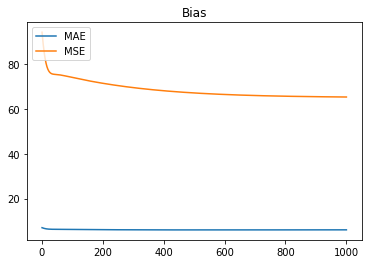

In [81]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('Bias')

plt.show()

In [82]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  6.068747276263974
testing data MAE is  65.29408382029419


## Gradient descent (loss = Huber loss)

In [128]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [129]:
def model (x,b0,b1):
    y = b0 +  b1*x
    return y

In [130]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.ones(5112 , requires_grad = True)
beta1 = torch.ones(5112, requires_grad = True)

rate = 1e-2
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 1000
loss = nn.MSELoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = torch.abs(yhats_test - y_test)
    test_error_MAE[epoch] = torch.nanmean(r)
    test_error_MSE[epoch] = torch.nanmean(r*r)

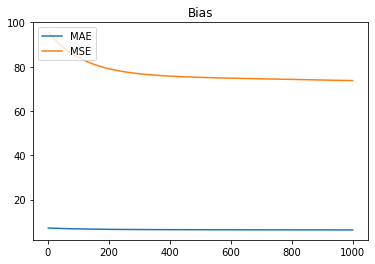

In [101]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('Bias')

plt.show()

In [102]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  6.2625390545144075
testing data MAE is  73.72465304468592


# Function on Function Model

## 公式解（PCA + Linear regression）

In [9]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [10]:
xper = np.zeros(5)
xper[0] = 0.85
xper[1] = 0.9
xper[2] = 0.95
xper[3] = 0.99
xper[4] = 0.995
yper = xper
test_error_MAE = 100*np.ones(25)
test_error_MSE = 100*np.ones(25)
MAE_index=[]
MSE_index=[]

In [11]:
for z in range (0,5):
    for w in range (0,5):
        pca_x = PCA(n_components=xper[z])
        pca_x.fit(x)
        x_pca=pca_x.transform(x)
        
        pca_y = PCA(n_components=yper[w])
        pca_y.fit(y)
        y_pca=pca_y.transform(y)
        
        model = LinearRegression()
        model.fit(x_pca, y_pca)

        xt_pca = pca_x.transform(xt)
        fit_x = model.predict(xt_pca)
        fit = pca_y.inverse_transform(fit_x)
        
        mae = np.mean(abs(fit-yt))
        mse = np.mean((fit-yt)**2)
        test_error_MAE[z*5+w] = mae
        test_error_MSE[z*5+w] = mse
        MAE_index.append((xper[z], yper[w], mae))
        MSE_index.append((xper[z], yper[w], mse))

In [12]:
f1 = np.argmin(test_error_MAE)
f2 = np.argmin(test_error_MSE)
print('test data on x = ', 100*MAE_index[f1][0], '% Y = ', 100*MAE_index[f1][1], '% have the min MAE error :', min(test_error_MAE))
print(MAE_index[f1])
print('test data on x = ', 100*MSE_index[f2][0], '% Y = ', 100*MSE_index[f2][1], '% have the min MSE error :', min(test_error_MSE))
print(MSE_index[f2])

test data on x =  90.0 % Y =  85.0 % have the min MAE error : 6.235844492460634
(0.9, 0.85, 6.235844492460634)
test data on x =  90.0 % Y =  85.0 % have the min MSE error : 63.31976640732784
(0.9, 0.85, 63.31976640732784)


## Gradient descent (loss = MAE)

In [103]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [104]:
def model (x,b0,b1):
    y = b0 + torch.matmul(x, b1)
    return y

In [105]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([5112,5112], requires_grad = True)

rate = 1e-4
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 500
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = abs(yhats_test - y_test)
    test_error_MAE[epoch] = torch.nanmean(r)
    test_error_MSE[epoch] = torch.nanmean(r*r)

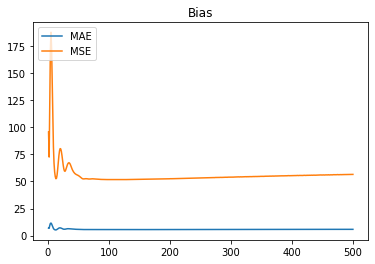

In [106]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('Bias')

plt.show()

In [107]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  5.289526840944239
testing data MAE is  51.661624716832065


## Gradient descent (loss = MSE)

In [112]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [113]:
def model (x,b0,b1):
    y = b0 + torch.matmul(x, b1)
    return y

In [114]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([5112,5112], requires_grad = True)

rate = 1e-4
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 500
loss = nn.MSELoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = abs(yhats_test - y_test)
    test_error_MAE[epoch] = torch.nanmean(r)
    test_error_MSE[epoch] = torch.nanmean(r*r)

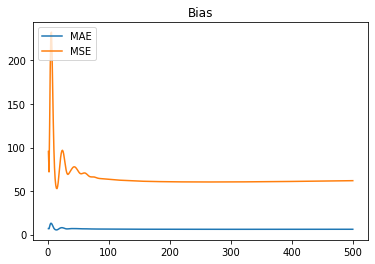

In [115]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('Bias')

plt.show()

In [116]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  5.4215726361349725
testing data MAE is  52.808986191639924


## Gradient descent (loss = Huber loss)

In [117]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [118]:
def model (x,b0,b1):
    y = b0 + torch.matmul(x, b1)
    return y

In [119]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([5112,5112], requires_grad = True)

rate = 1e-4
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 500
loss = nn.HuberLoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = abs(yhats_test - y_test)
    test_error_MAE[epoch] = torch.nanmean(r)
    test_error_MSE[epoch] = torch.nanmean(r*r)

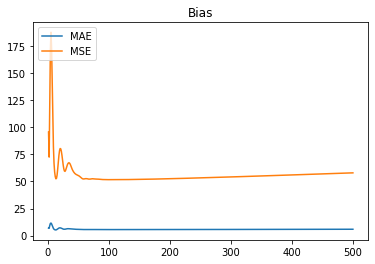

In [120]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('Bias')

plt.show()

In [121]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  5.287688356081604
testing data MAE is  51.645743527297626


# PLS Model

In [5]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [6]:
test_error_MAE = 100*np.ones(50)
test_error_MSE = 100*np.ones(50)
for n in range (1,51):
    model = PLSRegression(n_components=n,max_iter=1000)
    model.fit(x, y)

    xf=Xhat_test
    xfit=model.predict(xf)
    
    after_MAE=np.nanmean(abs(xfit-yt))
    after_MSE=np.nanmean((xfit-yt)**2)
    
    test_error_MAE[n-1] = after_MAE
    test_error_MSE[n-1] = after_MSE

In [7]:
print('test data on n = ', np.argmin(test_error_MAE)+1, 'have the min MAE error : ', min(test_error_MAE))
print('test data on n = ', np.argmin(test_error_MSE)+1, 'have the min MSE error : ', min(test_error_MSE))

test data on n =  29 have the min MAE error :  6.106423390382045
test data on n =  14 have the min MSE error :  59.39619033308034


# SIR Model

In [17]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [18]:
xper = np.zeros(5)
xper[0] = 0.85
xper[1] = 0.90
xper[2] = 0.95
xper[3] = 0.99
xper[4] = 0.995
yper = np.zeros(3)
yper[0] = 0.95
yper[1] = 0.99
yper[2] = 0.995
slices = np.zeros(5)
slices[0] = 10
slices[1] = 20
slices[2] = 30
slices[3] = 40
slices[4] = 50
test_error_MAE = 100*np.ones(15)
test_error_MSE = 100*np.ones(15)
index_MAE = []
index_MSE = []

In [19]:
for q in range (0,5):
    for r in range(0,3):
        pca_x = PCA(n_components=xper[q])
        pca_x.fit(x)
        x_pca=pca_x.transform(x)
        a = x_pca.shape[1]
        
        pca_y = PCA(n_components=yper[r])
        pca_y.fit(y)
        y_pca=pca_y.transform(y)
        b = y_pca.shape[1]

        xt_pca=pca_x.transform(xt)

        xt_svr = np.zeros([5,61,b])
        #5是因為有5種n_slices
        for j in range (0,5):
            for i in range (0,b):
                sir_x = SlicedInverseRegression(n_slices=slices[j])
                sir_x.fit(x_pca, y_pca[:,i])
                x_sir = sir_x.transform(x_pca)
                   
                svr = SVR()
                svr.fit(x_sir, y_pca[:,i])
                
                xt_sir = sir_x.transform(xt_pca) 
                xt_svr[j][:,i]=svr.predict(xt_sir)
        error1 = np.zeros(5)
        error2 = np.zeros(5)
        for i in range (0,5):
            yt_inv = pca_y.inverse_transform(xt_svr[i])
            error1[i] = np.mean(abs(yt_inv-yt))
            error2[i] = np.mean((yt_inv-yt)**2)

        n1 = 10*(np.argmin(error1)+1)
        n2 = 10*(np.argmin(error2)+1)
        min1 = min(error1)
        min2 = min(error2)
        index_MAE.append((xper[q], yper[r], n1, min1))    
        index_MSE.append((xper[q], yper[r], n2, min2)) 
        test_error_MAE[3*q+r] = min1
        test_error_MSE[3*q+r] = min2

In [20]:
f1 = np.argmin(test_error_MAE)
f2 = np.argmin(test_error_MSE)
print('test data on n_slices = ', index_MAE[f1][2], ', x = ', index_MAE[f1][0], '% , y = ', index_MAE[f1][1], '% have the min MAE error :', min(test_error_MAE))
print(index_MAE[f1])
print('test data on n_slices = ', index_MSE[f2][2], ', x = ', index_MSE[f2][0], '% , y = ', index_MSE[f2][1], '% have the min MSE error :', min(test_error_MSE))
print(index_MSE[f2])

test data on n_slices =  10 , x =  0.9 % , y =  0.95 % have the min MAE error : 5.480315058309686
(0.9, 0.95, 10, 5.480315058309686)
test data on n_slices =  10 , x =  0.9 % , y =  0.95 % have the min MSE error : 50.18138061447481
(0.9, 0.95, 10, 50.18138061447481)


# CNN Model

In [131]:
Xhat_train_n = np.zeros([71,544,72])
Yhat_train_n = np.zeros([71,544,72])
Xhat_test_n = np.zeros([71,61,72])
Yhat_test_n = np.zeros([71,61,72])
for i in range (0,71):
    for j in range (0,544):
        for k in range (0,72):
            Xhat_train_n[i][j][k] = Xhat_train[j][(72*i)+k]
            Yhat_train_n[i][j][k] = Yhat_train[j][(72*i)+k]
    for j in range (0,61):
        for k in range (0,72):
            Xhat_test_n[i][j][k] = Xhat_test[j][(72*i)+k]
            Yhat_test_n[i][j][k] = Yhat_test[j][(72*i)+k]
print('Xhat_train')
print(np.shape(Xhat_train_n))
print('Yhat_train')
print(np.shape(Yhat_train_n))
print('Xhat_test')
print(np.shape(Xhat_test_n))
print('Yhat_test')
print(np.shape(Yhat_test_n))
Xhat_val_n=Xhat_test_n
Yhat_val_n=Yhat_test_n
print('Xhat_val')
print(np.shape(Xhat_val_n))
print('Yhat_val')
print(np.shape(Yhat_val_n))

Xhat_train
(71, 544, 72)
Yhat_train
(71, 544, 72)
Xhat_test
(71, 61, 72)
Yhat_test
(71, 61, 72)
Xhat_val
(71, 61, 72)
Yhat_val
(71, 61, 72)


## loss = MAE

In [132]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv1d(1 , 32 , 2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Conv1d(32 , 32 , 2)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Conv1d(32, 32 , 2)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Conv1d(32 , 32 , 2)
        self.act4 = nn.ReLU()
        self.layer5 = nn.Conv1d(32 , 32 , 2)
        self.act5 = nn.ReLU()
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(67*32,264)
        self.fc2 = nn.Linear(264,72)
    
    def forward(self, x): 
        ouput = torch.unsqueeze(x,1)
        ouput = self.act1(self.layer1(ouput))
        ouput = self.act2(self.layer2(ouput))
        ouput = self.act3(self.layer3(ouput))
        ouput = self.act4(self.layer4(ouput))
        ouput = self.act5(self.layer5(ouput))
        ouput = self.fl(ouput)
        ouput = self.fc1(ouput)
        ouput = self.fc2(ouput)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=544 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
#         return {'loss' : loss , 'MAE' : mae, 'MSE' : mse}
        return {'loss' : loss}

    def test_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
#         return {'loss' : loss , 'MAE' : mae, 'MSE' : mse}
        return {'loss' : loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
#         return {'loss' : loss , 'MAE' : mae, 'MSE' : mse}
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("CNN Model", name="CNN_72hr_MAE")
    model = CNN() 
    trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [133]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/CNN Model/CNN_72hr_MAE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

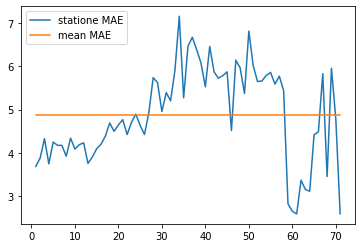

In [134]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

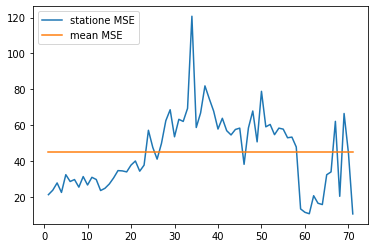

In [135]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [136]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  4.870982274203233
testing data MAE is  44.83770708970621


## loss = MSE

In [137]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv1d(1 , 32 , 2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Conv1d(32 , 32 , 2)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Conv1d(32, 32 , 2)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Conv1d(32 , 32 , 2)
        self.act4 = nn.ReLU()
        self.layer5 = nn.Conv1d(32 , 32 , 2)
        self.act5 = nn.ReLU()
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(67*32,264)
        self.fc2 = nn.Linear(264,72)
    
    def forward(self, x): 
        ouput = torch.unsqueeze(x,1)
        ouput = self.act1(self.layer1(ouput))
        ouput = self.act2(self.layer2(ouput))
        ouput = self.act3(self.layer3(ouput))
        ouput = self.act4(self.layer4(ouput))
        ouput = self.act5(self.layer5(ouput))
        ouput = self.fl(ouput)
        ouput = self.fc1(ouput)
        ouput = self.fc2(ouput)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=544 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
#        return {'loss' : loss , 'MAE' : mae, 'MSE' : mse}
        return {'loss' : loss}

    def test_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
#        return {'loss' : loss , 'MAE' : mae, 'MSE' : mse}
        return {'loss' : loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
#        return {'loss' : loss , 'MAE' : mae, 'MSE' : mse}
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("CNN Model", name="CNN_72hr_MSE")
    model = CNN() 
    trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [138]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/CNN Model/CNN_72hr_MSE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

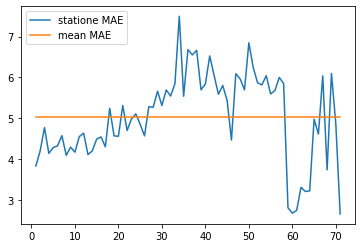

In [139]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

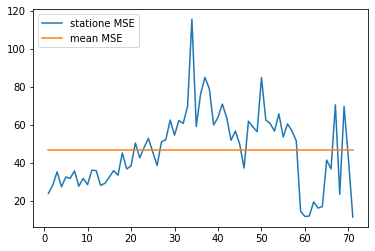

In [140]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [141]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  5.0312192708673615
testing data MAE is  47.02368362856583


## loss = Huber loss

In [142]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv1d(1 , 32 , 2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Conv1d(32 , 32 , 2)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Conv1d(32, 32 , 2)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Conv1d(32 , 32 , 2)
        self.act4 = nn.ReLU()
        self.layer5 = nn.Conv1d(32 , 32 , 2)
        self.act5 = nn.ReLU()
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(67*32,264)
        self.fc2 = nn.Linear(264,72)
    
    def forward(self, x): 
        ouput = torch.unsqueeze(x,1)
        ouput = self.act1(self.layer1(ouput))
        ouput = self.act2(self.layer2(ouput))
        ouput = self.act3(self.layer3(ouput))
        ouput = self.act4(self.layer4(ouput))
        ouput = self.act5(self.layer5(ouput))
        ouput = self.fl(ouput)
        ouput = self.fc1(ouput)
        ouput = self.fc2(ouput)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=544 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
#         return {'loss' : loss , 'MAE' : mae, 'MSE' : mse}
        return {'loss' : loss}

    def test_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
#         return {'loss' : loss , 'MAE' : mae, 'MSE' : mse}
        return {'loss' : loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
#         return {'loss' : loss , 'MAE' : mae, 'MSE' : mse}
        return {'loss' : loss}  

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("CNN Model", name="CNN_72hr_Huber")
    model = CNN() 
    trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [143]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/CNN Model/CNN_72hr_Huber/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

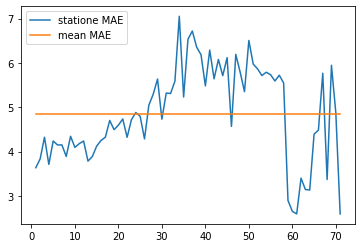

In [144]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

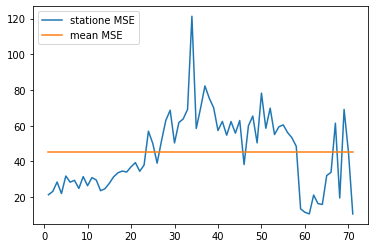

In [145]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [146]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  4.854074588963683
testing data MAE is  45.171984726274516


# Transformer Model

In [147]:
Xhat_train_n = np.zeros([71,544,72])
Yhat_train_n = np.zeros([71,544,72])
Xhat_test_n = np.zeros([71,61,72])
Yhat_test_n = np.zeros([71,61,72])
for i in range (0,71):
    for j in range (0,544):
        for k in range (0,72):
            Xhat_train_n[i][j][k] = Xhat_train[j][(72*i)+k]
            Yhat_train_n[i][j][k] = Yhat_train[j][(72*i)+k]
    for j in range (0,61):
        for k in range (0,72):
            Xhat_test_n[i][j][k] = Xhat_test[j][(72*i)+k]
            Yhat_test_n[i][j][k] = Yhat_test[j][(72*i)+k]
print('Xhat_train')
print(np.shape(Xhat_train_n))
print('Yhat_train')
print(np.shape(Yhat_train_n))
print('Xhat_test')
print(np.shape(Xhat_test_n))
print('Yhat_test')
print(np.shape(Yhat_test_n))
Xhat_val_n=Xhat_test_n
Yhat_val_n=Yhat_test_n
print('Xhat_val')
print(np.shape(Xhat_val_n))
print('Yhat_val')
print(np.shape(Yhat_val_n))

Xhat_train
(71, 544, 72)
Yhat_train
(71, 544, 72)
Xhat_test
(71, 61, 72)
Yhat_test
(71, 61, 72)
Xhat_val
(71, 61, 72)
Yhat_val
(71, 61, 72)


In [148]:
Xhat_train_n0 = np.zeros([71, 544, 144])
Xhat_val_n0 = np.zeros([71, 61, 144])
Xhat_test_n0 = np.zeros([71, 61, 144])
for k in range(0,71):
    for i in range (0,544):
        for j in range (0,72):
            Xhat_train_n0[k][i][j] = Xhat_train_n[k][i][j]
        for j in range (72,144):
            Xhat_train_n0[k][i][j] = Yhat_train_n[k][i][j-72]
for k in range(0,71):
    for i in range (0,61):
        for j in range (0,72):
            Xhat_val_n0[k][i][j] = Xhat_val_n[k][i][j]
        for j in range (72,144):
            Xhat_val_n0[k][i][j] = Yhat_val_n[k][i][j-72]
for k in range(0,71):
    for i in range (0,61):
        for j in range (0,72):
            Xhat_test_n0[k][i][j] = Xhat_test_n[k][i][j]
        for j in range (72,144):
            Xhat_test_n0[k][i][j] = Yhat_test_n[k][i][j-72]
print('Xhat_train')
print(np.shape(Xhat_train_n0))
print('Yhat_train')
print(np.shape(Yhat_train_n))
print('Xhat_test')
print(np.shape(Xhat_test_n0))
print('Yhat_test')
print(np.shape(Yhat_test_n))
print('Xhat_val')
print(np.shape(Xhat_val_n0))
print('Yhat_val')
print(np.shape(Yhat_val_n))

Xhat_train
(71, 544, 144)
Yhat_train
(71, 544, 72)
Xhat_test
(71, 61, 144)
Yhat_test
(71, 61, 72)
Xhat_val
(71, 61, 144)
Yhat_val
(71, 61, 72)


## loss = MAE

In [149]:
class Transformer(pl.LightningModule): 
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Transformer(d_model=72, nhead=72)
    
    def forward(self, x):
        ouput = self.layer1(x[:,:72], x[:,72:]) 
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-2) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=544 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
#        return {'loss' : loss , 'MAE' : mae, 'MSE' : mse}
        return {'loss' : loss}

    def test_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
#        return {'loss' : loss , 'MAE' : mae, 'MSE' : mse}
        return {'loss' : loss}

    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
#        return {'loss' : loss , 'MAE' : mae, 'MSE' : mse}
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n0[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n0[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n0[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("Transformer Model", name="Transformer_72hr_MAE")
    model = Transformer() 
    trainer = pl.Trainer(max_epochs=1500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [5]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/Transformer Model2/Transformer_72hr_MAE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

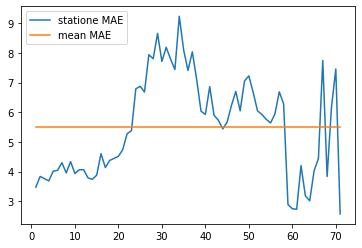

In [6]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

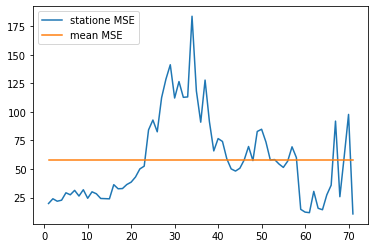

In [7]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [8]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  5.505435362668105
testing data MAE is  58.302218920748


## loss = MSE*

In [154]:
class Transformer(pl.LightningModule): 
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Transformer(d_model=72, nhead=72)
    
    def forward(self, x):
        ouput = self.layer1(x[:,:72], x[:,72:]) 
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-2) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=544 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
#        return {'loss' : loss , 'MAE' : mae, 'MSE' : mse}
        return {'loss' : loss}

    def test_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
#        return {'loss' : loss , 'MAE' : mae, 'MSE' : mse}
        return {'loss' : loss}

    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
#        return {'loss' : loss , 'MAE' : mae, 'MSE' : mse}
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n0[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n0[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n0[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("Transformer Model", name="Transformer_72hr_MSE")
    model = Transformer() 
    trainer = pl.Trainer(max_epochs=1500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [6]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/Transformer Model2/Transformer_72hr_MSE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

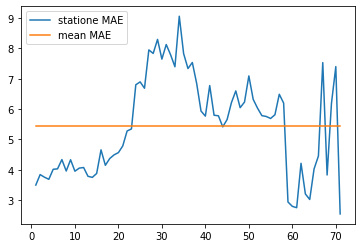

In [7]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

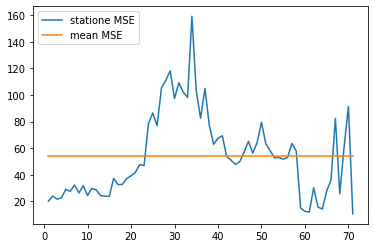

In [8]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [9]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  5.450318390214947
testing data MAE is  53.90980927373322


## loss = Huber loss*

In [159]:
class Transformer(pl.LightningModule): 
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Transformer(d_model=72, nhead=72)
    
    def forward(self, x):
        ouput = self.layer1(x[:,:72], x[:,72:]) 
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-2) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=544 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
#        return {'loss' : loss , 'MAE' : mae, 'MSE' : mse}
        return {'loss' : loss}

    def test_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
#        return {'loss' : loss , 'MAE' : mae, 'MSE' : mse}
        return {'loss' : loss}

    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
#        return {'loss' : loss , 'MAE' : mae, 'MSE' : mse}
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n0[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n0[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n0[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("Transformer Model", name="Transformer_72hr_Huber")
    model = Transformer() 
    trainer = pl.Trainer(max_epochs=1500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [2]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/Transformer Model2/Transformer_72hr_Huber/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

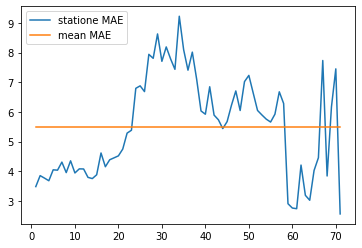

In [3]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

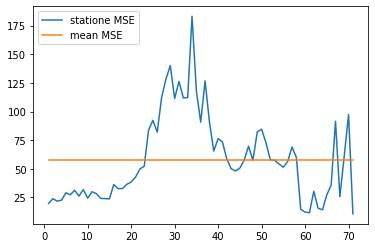

In [4]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [5]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  5.506157982517296
testing data MAE is  58.06173258768001
